<a href="https://colab.research.google.com/github/mrjames313/diffusion_model_co2_absorption/blob/main/CO2_absorbtion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
use_full_x = True  # Need to recreate the dataset if this gets changed
use_time = True
use_time_varying_c_gas = True # should also set use_time to True for the model to learn
A=0.2 # params for c_gas: oscillation amplitude, frequency, phase offset
f=0.8
phi=0.2

In [12]:
import math
import torch

def co2_rhs(t, x, k_abs, k_react, C_gas, A, f, phi):
    CO2, CaO, CaCO3 = x.unbind(-1)
    if use_time_varying_c_gas:
      C_gas_t = C_gas + A * torch.sin(torch.tensor(2*math.pi*f*t + phi))
      torch.clamp(C_gas_t, min=0)
    else:
      C_gas_t = C_gas

    absorb = k_abs * (C_gas_t - CO2)
    react  = k_react * CO2 * CaO
    dCO2   = absorb - react
    dCaO   = -react
    dCaCO3 =  react
    return torch.stack([dCO2, dCaO, dCaCO3], dim=-1)

# ---------- Fixed-step RK4 integrator ----------
def rk4(func, x0, t0=0.0, t1=10.0, dt=0.01, **f_kwargs):
    """
    Integrate x' = func(t, x) from t0 to t1 using RK4.
    x0: tensor [..., 3]; returns times [T] and states [T, ..., 3]
    """
    steps = int(math.ceil((t1 - t0) / dt))
    t = t0
    x = x0.clone()
    traj = [x]

    for _ in range(steps):
        k1 = func(t, x, **f_kwargs)
        k2 = func(t + dt/2, x + dt*k1/2, **f_kwargs)
        k3 = func(t + dt/2, x + dt*k2/2, **f_kwargs)
        k4 = func(t + dt,   x + dt*k3,   **f_kwargs)
        x = x + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)

        # keep concentrations non-negative (simple physical clamp)
        x = torch.clamp(x, min=0.0)
        traj.append(x)
        t += dt

    times = torch.linspace(t0, t1, steps+1)
    return times, torch.stack(traj, dim=0)  # [T, ..., 3]


# ---------- Quick smoke test: one trajectory ----------
x0 = torch.tensor([0.0, 1.0, 0.0])  # start with no dissolved CO2, CaO=1, no CaCO3
times, states = rk4(
    co2_rhs, x0,
    t0=0.0, t1=5.0, dt=0.01,
    k_abs=0.8, k_react=0.6, C_gas=1.0,
    A=0.1, f=0.5, phi=0.1
)

print("times:", times.shape, "states:", states.shape)
print("final state ~", states[-1])
print(states)


times: torch.Size([501]) states: torch.Size([501, 3])
final state ~ tensor([0.8455, 0.1686, 0.8314])
tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00],
        [8.0360e-03, 9.9998e-01, 2.4151e-05],
        [1.5985e-02, 9.9990e-01, 9.6253e-05],
        ...,
        [8.4485e-01, 1.7030e-01, 8.2970e-01],
        [8.4519e-01, 1.6944e-01, 8.3056e-01],
        [8.4550e-01, 1.6858e-01, 8.3142e-01]])


In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
import random

# ---------- Helper: generate one trajectory and sample points ----------
def sample_from_one_traj(
    k_abs, k_react, C_gas,
    A, f, phi,
    x0, T=5.0, dt=0.01, n_samples=64
):
    # Integrate with RK4 from Step 1
    times, states = rk4(
        co2_rhs, x0,
        t0=0.0, t1=T, dt=dt,
        k_abs=k_abs, k_react=k_react, C_gas=C_gas,
        A=A, f=f, phi=phi
    )  # times: [Tsteps], states: [Tsteps, 3]

    # Randomly pick time indices (avoid very first/last for stability)
    idxs = torch.randint(low=1, high=len(times)-1, size=(n_samples,))
    t = times[idxs].unsqueeze(1)                 # [n, 1]
    x_t = states[idxs]                           # [n, 3]
    # Compute ground-truth dx/dt at those points
    dx_t = co2_rhs(t.squeeze(1), x_t,
                   k_abs=k_abs, k_react=k_react, C_gas=C_gas, A=A, f=f, phi=phi)  # [n, 3]
    return t, x_t, dx_t

# ---------- Full dataset (many trajectories, random params) ----------
class CO2FlowDataset(Dataset):
    def __init__(self,
                 n_trajs=200,
                 samples_per_traj=64,
                 T=5.0, dt=0.01,
                 k_abs_range=(0.4, 1.2),
                 k_react_range=(0.3, 1.0),
                 C_gas_range=(0.8, 1.2),
                 A=0.1,
                 f=0.5,
                 phi=0.2,
                 use_full_x = False,
                 seed=42):
        super().__init__()
        g = torch.Generator().manual_seed(seed)
        random.seed(seed)
        print(f"use_full_x is {use_full_x}")

        t_list, x_list, dx_list = [], [], []

        for _ in range(n_trajs):
            # Random params for this trajectory
            k_abs   = random.uniform(*k_abs_range)
            k_react = random.uniform(*k_react_range)
            C_gas   = random.uniform(*C_gas_range)

            # Random initial conditions (non-negative, reasonable)
            # Start with some CaO present, little/no CaCO3, and small dissolved CO2
            x0 = torch.tensor([
                max(0.0, random.uniform(0.0, 0.2)),  # CO2 dissolved
                max(0.2, random.uniform(0.5, 1.5)),  # CaO
                max(0.0, random.uniform(0.0, 0.1)),  # CaCO3
            ], dtype=torch.float32)

            t, x_t, dx_t = sample_from_one_traj(
                k_abs, k_react, C_gas, A, f, phi, x0,
                T=T, dt=dt, n_samples=samples_per_traj
            )
            t_list.append(t)
            if use_full_x:
              params = torch.tensor([[k_abs, k_react, C_gas]])     # shape [1, 3]
              x_list.append(torch.cat([x_t, params.expand(x_t.size(0), -1)], dim=1))
            else:
              x_list.append(x_t)
            dx_list.append(dx_t)

        self.t = torch.cat(t_list, dim=0).float()      # [N, 1]
        self.x = torch.cat(x_list, dim=0).float()      # [N, 3] or [N, 6]
        self.dx = torch.cat(dx_list, dim=0).float()    # [N, 3]

        # Optional: simple normalization (helps training)
        # Compute stats on x and dx; store for later inverse-transform if needed
        self.x_mean = self.x.mean(0, keepdim=True)
        self.x_std  = self.x.std(0, keepdim=True).clamp_min(1e-6)
        self.dx_mean = self.dx.mean(0, keepdim=True)
        self.dx_std  = self.dx.std(0, keepdim=True).clamp_min(1e-6)

        print("x mean/std:", self.x_mean, self.x_std)
        print("dx mean/std:", self.dx_mean, self.dx_std)

    def __len__(self):
        return self.t.shape[0]

    def __getitem__(self, i):
        #t = self.t[i:i+1]                 # [1,1] - MRJ - why?
        t = self.t[i]                 # [1]
        x = self.x[i]                     # [3] or [6]
        dx = self.dx[i]                   # [3]

        # Normalize x and dx (t stays in [0, T] — we’ll re-scale to [0,1] next)
        x_n  = (x - self.x_mean[0]) / self.x_std[0]
        dx_n = (dx - self.dx_mean[0]) / self.dx_std[0]

        return t, x_n, dx_n

# ---------- Build dataset and dataloader ----------
train_ds = CO2FlowDataset(n_trajs=200, samples_per_traj=128, T=5.0, A=A, f=f, phi=phi, dt=0.01, use_full_x=use_full_x)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

# Quick sanity check:
batch = next(iter(train_loader))
t_b, x_b, dx_b = batch
print("t batch:", t_b.shape, "x batch:", x_b.shape, "dx batch:", dx_b.shape)
print("t example (raw seconds):", t_b[0].item())


use_full_x is True


/tmp/ipython-input-615536365.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  C_gas_t = C_gas + A * torch.sin(torch.tensor(2*math.pi*f*t + phi))


x mean/std: tensor([[0.6114, 0.5287, 0.5186, 0.8163, 0.6535, 1.0052]]) tensor([[0.2133, 0.3314, 0.3095, 0.2255, 0.2075, 0.1127]])
dx mean/std: tensor([[ 0.1377, -0.1641,  0.1641]]) tensor([[0.1956, 0.0797, 0.0797]])
t batch: torch.Size([128, 1]) x batch: torch.Size([128, 6]) dx batch: torch.Size([128, 3])
t example (raw seconds): 4.800000190734863


In [15]:
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

# Quick sanity check:
batch = next(iter(train_loader))
#print(batch)
t_b, x_b, dx_b = batch
print("t batch:", t_b.shape, "x batch:", x_b.shape, "dx batch:", dx_b.shape)

t batch: torch.Size([128, 1]) x batch: torch.Size([128, 6]) dx batch: torch.Size([128, 3])


In [16]:
# Just checking the computations for rk4
t, x = 1.0, torch.tensor([[0.2, 1.0, 0.0]])
dt = 1e-3
dx_true = co2_rhs(t, x, k_abs=0.8, k_react=0.6, C_gas=1.0, A=A, f=f, phi=phi)
_, states = rk4(co2_rhs, x[0], t0=t, t1=t+dt, dt=dt, k_abs=0.8, k_react=0.6, C_gas=1.0, A=A, f=f, phi=phi)
dx_fd = (states[-1] - x).squeeze(0) / dt
print("MSE(rhs vs finite-diff):", torch.mean((dx_true - dx_fd)**2).item())

MSE(rhs vs finite-diff): 8.856313904459512e-09


In [25]:
!nvidia-smi


# =========================
# Step 3 — Model + Training
# =========================
import math, torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# ---- 3.1  Utility: time → [0,1] ----
# We sampled times in [0, T]. Normalize to [0,1] for conditioning.
T_total = train_ds.t.max().item()  # from Step 2 dataset
def normalize_time(t):  # t: [B,1] in seconds
    return (t / T_total).clamp(0.0, 1.0)

# ---- 3.2  (Optional) sinusoidal time embedding ----
class TimeEmbedding(nn.Module):
    def __init__(self, embed_dim=32):
        super().__init__()
        # linearly spaced in [0,1) then mapped exponentially to span multiple scales
        freqs_lin = torch.arange(0, embed_dim//2) / (embed_dim/2)
        freqs = torch.exp(-math.log(10000.0) * freqs_lin) * (2*math.pi)  # scale by 2π for better coverage on t∈[0,1]
        self.register_buffer("freqs", freqs)  # not a parameter, but saved & moved with the model

    def forward(self, t01):  # [B,1] in [0,1]
        # broadcast multiply: [B,1] * [F] -> [B,F]
        w = t01 * self.freqs[None, :]
        return torch.cat([torch.sin(w), torch.cos(w)], dim=-1)  # [B, F*2]

# ---- 3.3  MLP that predicts dx/dt given (t, x) ----
class CO2FlowNet(nn.Module):
    def __init__(self, x_dim=3, t_embed_dim=32, hidden=128, depth=3, use_full_x=False, use_time=True):
        super().__init__()
        if not use_time:
          t_embed_dim=0

        self.tok = TimeEmbedding(embed_dim=t_embed_dim)  # produces 2*(t_embed_dim//2) features

        in_dim = x_dim + t_embed_dim  # concatenate x and time embedding
        if use_full_x:
          in_dim += 3

        layers = []
        dim = in_dim
        for _ in range(depth):
            layers += [nn.Linear(dim, hidden), nn.SiLU()]
            dim = hidden
        layers += [nn.Linear(dim, x_dim)]  # output dx/dt
        self.net = nn.Sequential(*layers)

    def forward(self, t01, x):  # t01: [B,1], x: [B,3] (normalized)
        te = self.tok(t01)      # [B, t_embed_dim]
        h = torch.cat([x, te], dim=-1)
        return self.net(h)      # [B,3]

model = CO2FlowNet(x_dim=3, t_embed_dim=32, hidden=128, depth=4, use_full_x=use_full_x, use_time=use_time).to(device)
#optim = torch.optim.Adam(model.parameters(), lr=1e-3)
# NEXT TWO ARE NEW
optim = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=50)

loss_fn = nn.MSELoss()

# ---- 3.4  Training loop ----
epochs = 40          # start small; you can raise to 50–200
log_every = 100
model.train()

# Look at the dataset and make sure it makes sense
print(f"Dataset times min {train_ds.t.min().item()} and max {train_ds.t.max().item()}")
print("x std:", train_ds.x_std)
print("dx std:", train_ds.dx_std)

for ep in range(1, epochs+1):
    running = 0.0
    for it, (t, x_n, dx_n) in enumerate(train_loader, 1):
        t = t.to(device).float()          # [B,1] raw seconds
        t01 = normalize_time(t)           # [B,1] in [0,1]
        x_n = x_n.to(device).float()      # [B,3] normalized states (from dataset)
        dx_n = dx_n.to(device).float()    # [B,3] normalized derivatives (target)

        # forward -> loss
        pred = model(t01, x_n)            # [B,3] normalized prediction
        loss = loss_fn(pred, dx_n)

        # backward
        optim.zero_grad(set_to_none=True)
        loss.backward()
        optim.step()
        sched.step()  # NEW

        running += loss.item()
        if it % log_every == 0:
            print(f"epoch {ep:02d}  iter {it:04d}  loss {running/log_every:.6f}")
            running = 0.0

print("Done training.")


Fri Oct 24 03:40:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P0             30W /   70W |     160MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

/tmp/ipython-input-615536365.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  C_gas_t = C_gas + A * torch.sin(torch.tensor(2*math.pi*f*t + phi))


RMSE over time (avg per step): 0.031068
Final absolute error: [0.049639880657196045, 0.01800891011953354, 0.01414412260055542]
Final relative error: [0.05842810124158859, 0.1292770951986313, 0.014722802676260471]


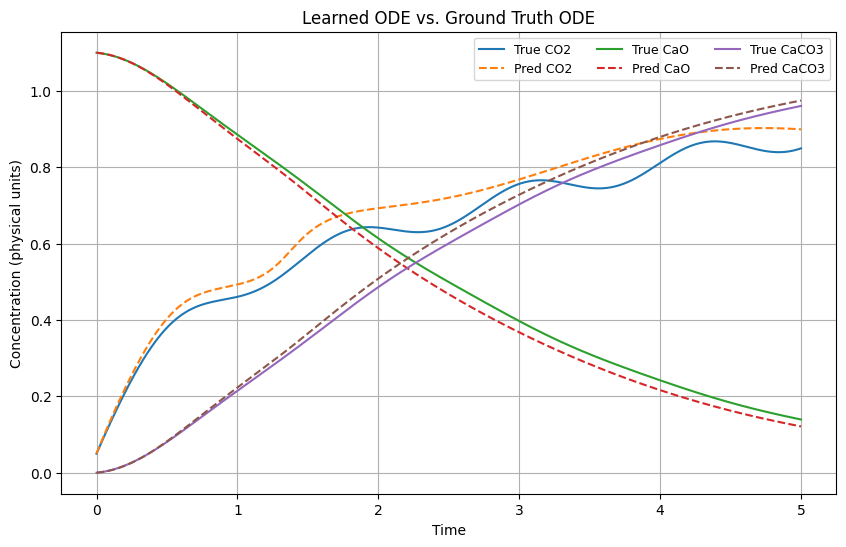

In [26]:
import torch, math
import matplotlib.pyplot as plt

# ====== Config ======
T0, T1, DT = 0.0, 5.0, 0.01
params = dict(k_abs=0.85, k_react=0.65, C_gas=1.05)  # pick any test set values
x0_phys = torch.tensor([0.05, 1.10, 0.00], dtype=torch.float32)  # initial physical state

device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval()

# ====== Helpers: normalization stats (from your dataset) ======
# Use the same stats the model was trained with.
x_mean = train_ds.x_mean[0].to(device)   # [3]
x_std  = train_ds.x_std[0].to(device)    # [3]
dx_mean = train_ds.dx_mean[0].to(device) # [3]
dx_std  = train_ds.dx_std[0].to(device)  # [3]

# If you normalized t to [0,1] using a global T_total, re-use it:
try:
    T_total
except NameError:
    # Fallback: compute from the original (non-Subset) dataset if you have it,
    # otherwise from train_ds as an approximation.
    T_total = train_ds.t.max().item()

def to_time01(t_scalar):
    return torch.tensor([[t_scalar / T_total]], dtype=torch.float32, device=device).clamp(0,1)

# ====== Learned RHS wrapper (produces physical dx/dt) ======
@torch.no_grad()
def rhs_model(t_scalar, x_phys, params, use_full_x=False):
    """
    x_phys: [3] on CPU
    returns dx_phys: [3] on CPU
    """

    # pack parameters (raw, as trained)
    p = torch.tensor([params["k_abs"], params["k_react"], params["C_gas"]],
                     dtype=torch.float32, device=device).unsqueeze(0)  # [1,3]
    x_n = x_phys.to(device).unsqueeze(0)
    if use_full_x:
      x_n = torch.cat([x_n, p], dim=1)

    # normalize x to the model's input space
    x_n = ((x_n - x_mean) / x_std)  # [1,3] or [1,6]

    t01 = to_time01(t_scalar)  # model takes in time, and has internal switch to use it or not
    dx_n = model(t01, x_n)

    # denormalize derivative back to physical space
    dx_phys = (dx_n.squeeze(0) * dx_std + dx_mean).to("cpu")  # [3] or [6]
    return dx_phys

# ====== Integrators (true ODE and learned ODE) ======
def integrate_rhs_rk4(rhs_fn, x0_cpu, t0, t1, dt):
    steps = int(math.ceil((t1 - t0) / dt))
    t = t0
    x = x0_cpu.clone()
    traj = [x.clone()]
    for _ in range(steps):
        k1 = rhs_fn(t, x)
        k2 = rhs_fn(t + dt/2, x + dt*k1/2)
        k3 = rhs_fn(t + dt/2, x + dt*k2/2)
        k4 = rhs_fn(t + dt,   x + dt*k3)
        x = x + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)
        x = torch.clamp(x, min=0.0)
        traj.append(x.clone())
        t += dt
    times = torch.linspace(t0, t1, steps+1)
    return times, torch.stack(traj, dim=0)  # [T,3]

# Ground-truth RHS adapter (expects CPU tensors)
def rhs_true(t_scalar, x_cpu):
    return co2_rhs(
        torch.tensor(t_scalar, dtype=torch.float32),
        x_cpu,
        k_abs=params["k_abs"], k_react=params["k_react"], C_gas=params["C_gas"],
        A=A, f=f, phi=phi
    )

# Learned RHS adapter
def rhs_learned(t_scalar, x_cpu):
    return rhs_model(t_scalar, x_cpu, params, use_full_x=use_full_x)

# ====== Run both integrations ======
times_true, traj_true = integrate_rhs_rk4(rhs_true,   x0_phys, T0, T1, DT)  # [T,3]
times_pred, traj_pred = integrate_rhs_rk4(rhs_learned, x0_phys, T0, T1, DT) # [T,3]

# ====== Metrics ======
with torch.no_grad():
    diff = traj_pred - traj_true
    rmse_over_time = torch.sqrt((diff.pow(2).mean(dim=1))).mean().item()  # mean RMSE across time
    final_abs_err = (traj_pred[-1] - traj_true[-1]).abs()
    final_rel_err = final_abs_err / (traj_true[-1].abs() + 1e-8)

print(f"RMSE over time (avg per step): {rmse_over_time:.6f}")
print("Final absolute error:", final_abs_err.tolist())
print("Final relative error:", final_rel_err.tolist())

# ====== Plot ======
labels = ["CO2", "CaO", "CaCO3"]
plt.figure(figsize=(10,6))
for d in range(3):
    plt.plot(times_true, traj_true[:, d], label=f"True {labels[d]}")
    plt.plot(times_pred, traj_pred[:, d], linestyle="--", label=f"Pred {labels[d]}")
plt.xlabel("Time")
plt.ylabel("Concentration (physical units)")
plt.title("Learned ODE vs. Ground Truth ODE")
plt.legend(ncol=3, fontsize=9)
plt.grid(True)
plt.show()
